# Analysis Data (Brand-35)

In [1]:
import sys
sys.path.append('..')

from utilities import *

warnings.filterwarnings('ignore')

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data[sa.brand35]

train_data, test_data = sa.divide_data_for_train_and_test(data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Regression-lineal table

In [2]:
model, design_info, selected_columns = sa.modelization_with_backward_elimination(train_data)

Convert interactions in variables exogenous for input to our model

In [3]:
X_train_exog = sa.x_train_exog(train_data, selected_columns, model)

✅ YES - All features match perfectly!


#### Run Auto ARIMA model with exogenous variables

In [4]:
# Now we can run auto_arima with the correct exogenous variables
auto_arima_model = auto_arima( 
    y=train_data['volume.sales'],
    X=X_train_exog,  # Use the properly formatted exogenous variables
    start_p=0,
    d=1,  
    start_q=0,
    max_p=3, 
    max_q=3,
    start_P=0,
    D=1,  # Set seasonal differencing explicitly
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,  # Monthly data
    seasonal=True,
    trace=True,
    error_action="warn",  # Change to warn to see potential issues
    suppress_warnings=True,
    stepwise=True, # False to see all models and not only the best 
    # random_state=42, # Useful for random research
    n_fits=50,
    information_criterion='aic'
)

print("Auto ARIMA model fitted successfully!")
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18700.911, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=14983.257, Time=11.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=80.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15113.277, Time=0.56 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=28.51 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=24.81 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=15113.200, Time=10.37 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=14940.126, Time=18.26 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=15067.640, Time=0.94 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=35.49 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=27.19 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=14902.971, Time=17.14 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=15033.538, Time=1.79 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=29.71 sec
 ARIMA(3,1,0)(0,1,1)[12]       

In [5]:
import importlib
import utilities
importlib.reload(utilities)

<module 'utilities' from '/Users/oscarjimenezbou/Documents/TFG_ADE/code/main/../utilities.py'>

#### Check the residuals for white noise

-----------------Residues Analysis (White Noise) -----------------
[Heteroscedasticity Test] ARCH p-value: 4.80189902198319e-11 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 4.601860723233844e-50 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 7.320723375739127e-12 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
        lb_stat     lb_pvalue
10  102.058246  2.109089e-17 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 2.1436117794872604 -- range(2.0)
-----------------Residues Analysis (Stationarity) -----------------
Estadístico ADF: -7.853404794535187
Valor p: 5.5237520752949304e-12 -- es estacionaria si p < 0.05
Valores críticos:
1%: -3.440890045708521
5%: -2.8661904001753618
10%: -2.569246579178572
-----------------Residues Analysis (Correlation) -----------------


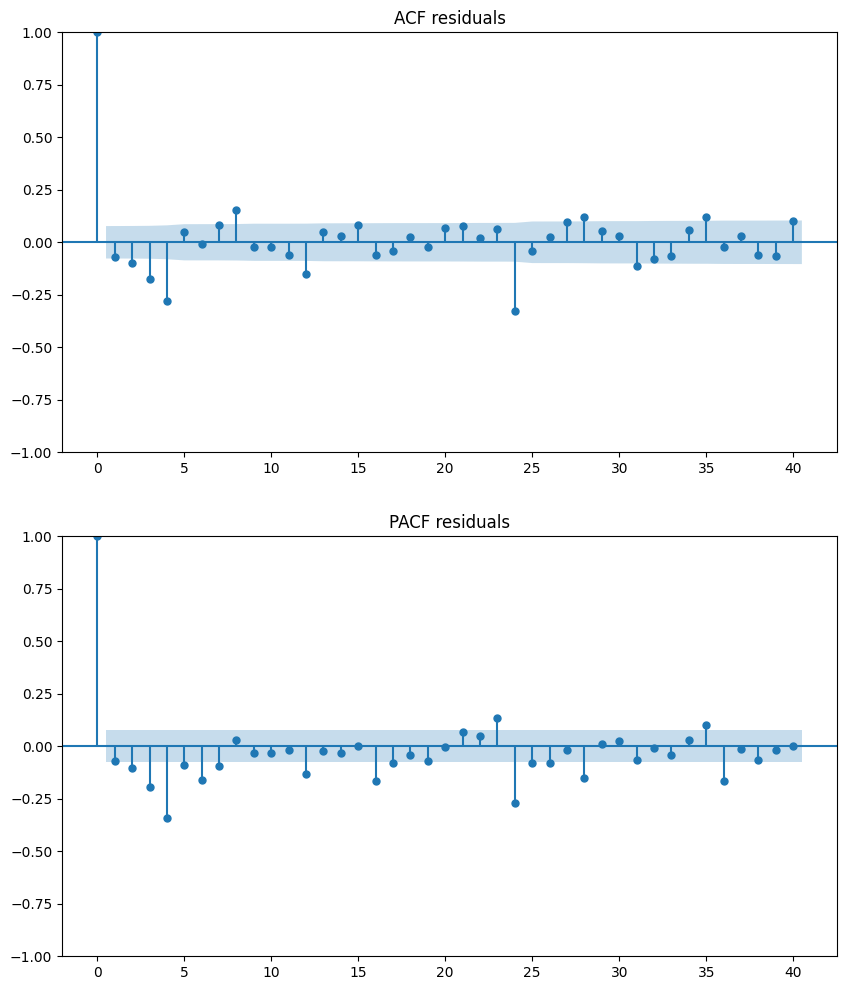

,lb_stat,lb_pvalue
10,102.058246,2.109089e-17


In [6]:

# Get residuals from the underlying statsmodels model
# In pmdarima, residuals are accessed via arima_res_.resid
residuals = auto_arima_model.arima_res_.resid

print("-----------------Residues Analysis (White Noise) -----------------")
sa.residual_white_noise_test(residuals)
print("-----------------Residues Analysis (Stationarity) -----------------")
sa.test_stationarity(pd.DataFrame({'volume.sales': residuals}), sales='volume.sales')
print("-----------------Residues Analysis (Correlation) -----------------")
sa.test_correlation_residues(residuals)

‼️ Conclude the model obtained in auto_arima is not white noise. The it's not valid!!!!

In [7]:
# Try many reasonable combinations manually, but set the max parameters to 3
possible_models = {
    "ARIMA(0,1,0)": (0, 1, 0),
    "ARIMA(1,1,0)": (1, 1, 0),
    "ARIMA(2,1,0)": (2, 1, 0),
    "ARIMA(3,1,0)": (3, 1, 0),
    "ARIMA(0,1,1)": (0, 1, 1),
    "ARIMA(1,1,1)": (1, 1, 1),
    "ARIMA(2,1,1)": (2, 1, 1),
    "ARIMA(3,1,1)": (3, 1, 1),
    "ARIMA(0,1,2)": (0, 1, 2),
    "ARIMA(1,1,2)": (1, 1, 2),
    "ARIMA(2,1,2)": (2, 1, 2),
    "ARIMA(3,1,2)": (3, 1, 2),
    "ARIMA(0,1,3)": (0, 1, 3),
    "ARIMA(1,1,3)": (1, 1, 3),
    "ARIMA(2,1,3)": (2, 1, 3),
    "ARIMA(3,1,3)": (3, 1, 3),
    "ARIMA(1,1,2)": (1, 1, 2),
    "ARIMA(2,1,1)": (2, 1, 1),
    "ARIMA(2,1,3)": (2, 1, 3),
    "ARIMA(3,1,1)": (3, 1, 1)
}
#FIXME: this is not correctly implemented. For use correctly: 
'''


model_brand35_manual = SARIMAX(
    endog=train_data['volume.sales'],
    exog=X_train_exog,  # variables exógenas
    order=(0, 1, 1),  # ARIMA(0,1,1)
    seasonal_order=(0, 1, 0, 12),  # (P, D, Q, s) = (0, 1, 0, 12)
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_brand35_manual_fitted = model_brand35_manual.fit()

residuals = model_brand35_manual_fitted.resid
'''
# Do ARIMAX for each model taking into account the exogenous variables

for modelo in possible_models:
    print(f"================== Fitting {modelo} ==================")
    try:
        # Fit ARIMAX model - exog as X_train_exog, endog as train_data["volume.sales"]
        model_brand35_arima = sa.ARIMAX(
            endog=train_data["volume.sales"],
            exog=X_train_exog,
            model_chosen=possible_models[modelo]
        )

        print("-----------------Residues Analysis (White Noise) -----------------")
        sa.residual_white_noise_test(model_brand35_arima.resid)
        print("------------------------------------------------------------------")
    except Exception as e:
        print(f"❌ Could not fit {modelo}: {e}")

================== Fitting ARIMA(0,1,0) ==================
-----------------Residues Analysis (White Noise) -----------------
[Heteroscedasticity Test] ARCH p-value: 1.0008233007404886e-31 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 3.138257583065583e-50 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 1.1516451641345758e-14 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
        lb_stat     lb_pvalue
10  140.507143  3.317413e-25 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 2.902694022606995 -- range(2.0)
------------------------------------------------------------------
================== Fitting ARIMA(1,1,0) ==================
-----------------Residues Analysis (White Noise) -----------------
[Heteroscedasticity Test] ARCH p-value: 3.38468143094492e-10 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 7.057595335898519e-70 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 1.3118570145518497e-14 -- range(> 0.05)
[

In [8]:
# the models select by his white noise property:
chosen_model = {
    "ARIMA(0,1,1)": (0, 1, 1),
    "ARIMA(1,1,1": (1, 1, 1),
    "ARIMA(0,1,2)": (0, 1, 2),
}

best_model = None
best_aic = float('inf')
best_bic = float('inf')

mejor_modelo = None
mejor_aic = float('inf')

for modelo in chosen_model:
    print(f"================== Fitting {modelo} ==================")
    try:
        # Fit ARIMAX model - exog as X_train_exog, endog as train_data["volume.sales"]
        model_brand35_arima = sa.ARIMAX(
            endog=train_data["volume.sales"],
            exog=X_train_exog,
            model_chosen=chosen_model[modelo]
        )
        print("-----------------Residues Analysis (White Noise) -----------------")
        sa.residual_white_noise_test(model_brand35_arima.resid)
        print("------------------------------------------------------------------") 
        print(f"AIC: {model_brand35_arima.aic}")
        print(f"BIC: {model_brand35_arima.bic}")

        '''
        The best model is the one with the lowest AIC
        '''
        if model_brand35_arima.aic < mejor_aic:
            mejor_aic = model_brand35_arima.aic
            mejor_modelo = modelo
    except Exception as e:
        print(f"❌ Could not fit {modelo}: {e}")

if mejor_modelo is not None:
    print(f"\Mejor modelo: {mejor_modelo} con AIC: {mejor_aic}")
else:
    print("\nNo se pudo encontrar un modelo válido según el AIC.")


================== Fitting ARIMA(0,1,1) ==================
-----------------Residues Analysis (White Noise) -----------------
[Heteroscedasticity Test] ARCH p-value: 0.29359756373907825 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 5.8314126368986245e-289 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 1.599655746436624e-22 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
       lb_stat  lb_pvalue
10  16.800212   0.078903 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 1.9075087627711869 -- range(2.0)
------------------------------------------------------------------
AIC: 14747.291575529383
BIC: 14876.809772532275
================== Fitting ARIMA(1,1,1 ==================
-----------------Residues Analysis (White Noise) -----------------
[Heteroscedasticity Test] ARCH p-value: 0.27189766975270113 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 4.0034490626418454e-283 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 1.

#### Prepare exogenous variables for test data
